# WheatFspm env-as-reservoir baseline dataset

The following notebook generates a dataset for training a baseline model using the meteorological model inputs as reservoir state.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

### Loading the real datasets

In [2]:
%reload_ext autoreload
%autoreload 2 

from model_config import targets, state_variables

In [3]:
DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

In [4]:
from src.model.rc_dataset import ExperimentDataset

dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

datasets = [
  ('NEMA_H0', dataset_nema_h0), 
  ('NEMA_H3', dataset_nema_h3), 
  ('NEMA_H15', dataset_nema_h15)
]

### Generating the environmental reservoir

In [5]:
from wheatfspm_pipeline_utils import preprocess_data, group_by_day, train_test_split_alternating
from wheatfspm_pipeline_utils import direct_target_generator, direct_reservoir_generator
from wheatfspm_pipeline_utils import preprocess_raw_X

from model_config import max_time_step, baseline_reservoirs

def generate_X_y_groups_baseline(
    *,
    datasets,
    target,
    env_targets,
    prefix,
    target_generator,
    warmup_steps,
    day_mask,
    combined_only=False,
):
    data = {}

    def _preprocess_data(target_data, reservoir_data):
        X_raw, y_raw = preprocess_data(target_data, reservoir_data, warmup_steps, day_mask, skip_normalize=True)
        X, y = X_raw[0, :, :], y_raw[0, :]
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        y = (y - y.mean()) / y.std()
        groups = group_by_day(X, day_mask)
        return X, y, groups
    
    def create_reservoir_from_targets(targets, run_name):
        target_data_list = [next(direct_target_generator(dataset, _target, run_name)) for _target in targets]
        target_data_nd = np.array(target_data_list).T
        return target_data_nd

    # Preprocess the data for each dataset
    for name, dataset in datasets:
        target_data = next(target_generator(dataset, target, name))
        reservoir_data = create_reservoir_from_targets(env_targets, name) 
        X, y, groups = _preprocess_data(target_data, reservoir_data)
        data[f'{name}_{prefix}'] = (X, y, groups)

    # Generate the concatenated dataset
    all_arrays = list(data.values())
    X_combined = np.concatenate(list(map(lambda x: x[0], all_arrays)))
    y_combined = np.concatenate(list(map(lambda x: x[1], all_arrays)))
    groups_combined = np.concatenate(list(map(lambda x: x[2], all_arrays)))
    data[f"combined_{prefix}"] = (X_combined, y_combined, groups_combined)
    if combined_only:
        data = { k : v for k, v in data.items() if k.startswith('combined') }

    return data


def generate_X_y_groups(
    *,
    datasets,
    target,
    state_var,
    target_generator,
    state_generator,
    warmup_steps,
    day_mask,
    combined_only=False,
    add_env=False,
):
    """Generates X, y and groups arrays for each dataset, plus a concatenated dataset.
    NOTE: The groups in the concatenated dataset are such that the same calendar day is in the same group.

    Also generates a baseline dataset where the reservoir is just a combination of all environmental inputs.
    """
    data = {}

    def _preprocess_data(target_data, reservoir_data):
        X_raw, y_raw = preprocess_data(target_data, reservoir_data, warmup_steps, day_mask)
        X, y = X_raw[0, :, :], y_raw[0, :]
        groups = group_by_day(X, day_mask)
        return X, y, groups

    # Preprocess the data for each dataset
    for name, dataset in datasets:
        target_data = next(target_generator(dataset, target, name))
        reservoir_data = next(state_generator(dataset, state_var, name))
        X, y, groups = _preprocess_data(target_data, reservoir_data)
        data[name] = (X, y, groups)

    # Generate the concatenated dataset
    all_arrays = list(data.values())
    X_combined = np.concatenate(list(map(lambda x: x[0], all_arrays)))
    y_combined = np.concatenate(list(map(lambda x: x[1], all_arrays)))
    groups_combined = np.concatenate(list(map(lambda x: x[2], all_arrays)))
    data["combined"] = (X_combined, y_combined, groups_combined)
    if combined_only:
        data = { k : v for k, v in data.items() if k.startswith('combined') }

    # Add environmental baselines
    if add_env:
        for prefix, env_targets in baseline_reservoirs:
            env_data = generate_X_y_groups_baseline(
                datasets=datasets,
                target=target,
                env_targets=env_targets,
                prefix=prefix,
                target_generator=target_generator,
                warmup_steps=warmup_steps,
                day_mask=day_mask,
                combined_only=combined_only)
            data = {**data, **env_data}

    return data

In [6]:
from src.learning.preprocessing import generate_mask


TARGET = targets[0]
STATE_VAR = state_variables[0]

WARMUP_STEPS = 4 * 24
DAY_MASK = generate_mask(5, 21)


preprocessed_data = generate_X_y_groups(
  datasets=datasets, 
  target=TARGET, 
  state_var=STATE_VAR, 
  target_generator=direct_target_generator, 
  state_generator=direct_reservoir_generator,
  warmup_steps=WARMUP_STEPS, 
  day_mask=DAY_MASK,
  combined_only=True,
  add_env=True
)

for name, (X, y, groups) in preprocessed_data.items():
  print(f'{name}:')
  print(f'\tX: {X.shape}')
  print(f'\ty: {y.shape}')
  print(f'\tgroups: {len(np.unique(groups))} (shape {groups.shape})')

combined:
	X: (1424, 10)
	y: (1424,)
	groups: 33 (shape (1424,))
combined_env_res:
	X: (1424, 3)
	y: (1424,)
	groups: 33 (shape (1424,))
combined_env_temp_only:
	X: (1424, 1)
	y: (1424,)
	groups: 33 (shape (1424,))


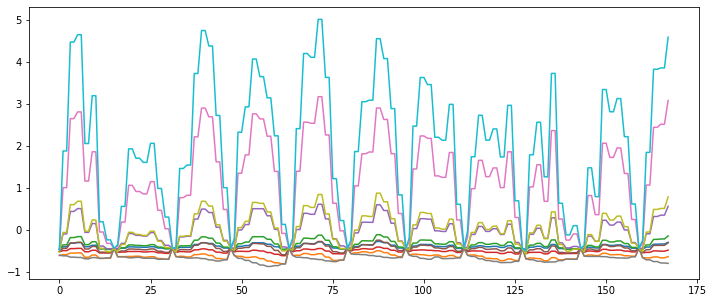

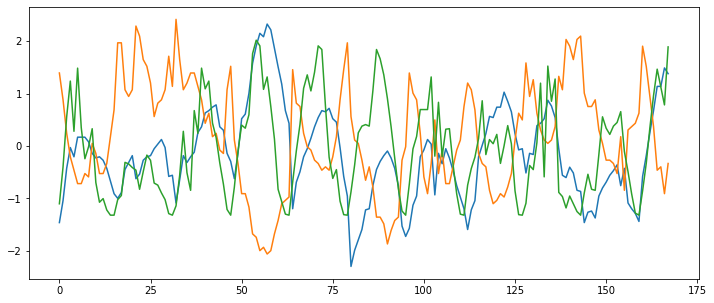

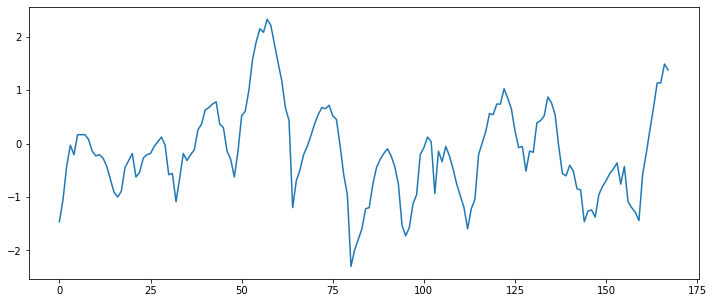

In [8]:
plt.figure(figsize=(12,5))
plt.plot(preprocessed_data['combined'][0][:7*24])
plt.show()
plt.figure(figsize=(12,5))
plt.plot(preprocessed_data['combined_env_res'][0][:7*24])
plt.show()
plt.figure(figsize=(12,5))
plt.plot(preprocessed_data['combined_env_temp_only'][0][:7*24])
plt.show()

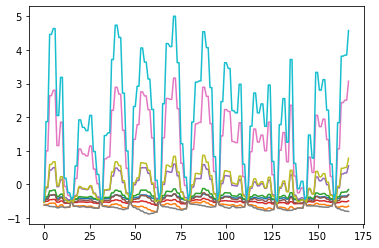

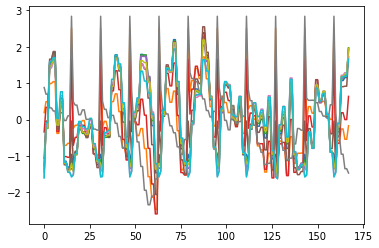

In [11]:
X = preprocessed_data['combined'][0][:7*24]

from sklearn.preprocessing import StandardScaler

plt.plot(X)
plt.show()

X = StandardScaler().fit_transform(X)

plt.plot(X)
plt.show()